<a href="https://colab.research.google.com/github/tomiambro/af-cnn-fastai/blob/main/AF_NN_Clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb &> 2

In [ ]:
import wfdb
import scipy.io
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import gc
from io import BytesIO
from PIL import Image, ImageDraw
from fastai.vision.all import *

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt

In [ ]:
path = '/content/drive/MyDrive/Datasets/training/cpsc_2018/g1/A0002'

# Load .hea header file
header = wfdb.rdheader(path)

print(header.__dict__)

# Load .mat binary file
mat_data = scipy.io.loadmat(f'{path}.mat')


# Extract ECG signal
ecg_signal = mat_data['val']

{'record_name': 'A0002', 'n_sig': 12, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 5000, 'base_time': None, 'base_date': None, 'comments': ['Age: 49', 'Sex: Female', 'Dx: 426783006', 'Rx: Unknown', 'Hx: Unknown', 'Sx: Unknown'], 'sig_name': ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': None, 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['A0002.mat', 'A0002.mat', 'A0002.mat', 'A0002.mat', 'A0002.mat', 'A0002.mat', 'A0002.mat', 'A0002.mat', 'A0002.mat', 'A0002.mat', 'A0002.mat', 'A0002.mat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'skew': [None, None, None, None, None, None, None, None, None, None, None, None], 'byte_offset': [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24], 'adc_gain': [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], 'baseline': [0, 0, 

In [ ]:
header.comments[2].split(": ")[1]

'426783006'

In [ ]:
def plot_ecg_subplots(ecg_data, sample_frequency):
    num_leads = ecg_data.shape[0]
    duration = ecg_data.shape[1] / sample_frequency
    time_values = np.linspace(0, duration, ecg_data.shape[1])

    fig, axs = plt.subplots(num_leads, 1, figsize=(18, 4 * num_leads), sharex=True)

    line_styles = ['-', '--', '-.', ':']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i in range(num_leads):
        axs[i].plot(time_values, ecg_data[i], linestyle=line_styles[i % len(line_styles)], color=colors[i % len(colors)])
        axs[i].set_ylabel(header.sig_name[i])
        axs[i].grid(True, linestyle='--', alpha=0.6)

    axs[-1].set_xlabel('Time (seconds)')
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `header.sig_name` is a list of lead names or labels
# Assuming `ecg_data` is a 2D NumPy array containing ECG data for each lead
# Assuming `header.fs` is the sample frequency



In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg

def plot_to_pil(ecg_data, sample_frequency):
  num_leads = ecg_data.shape[0]
  duration = ecg_data.shape[1] / sample_frequency
  time_values = np.linspace(0, duration, ecg_data.shape[1])

  fig, axs = plt.subplots(num_leads, 1, figsize=(18, 4 * num_leads), sharex=True)

  line_styles = ['-', '--', '-.', ':']
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

  for i in range(num_leads):
      axs[i].plot(time_values, ecg_data[i], linestyle=line_styles[i % len(line_styles)], color=colors[i % len(colors)])
      axs[i].set_ylabel(header.sig_name[i])
      axs[i].grid(True, linestyle='--', alpha=0.6)

  axs[-1].set_xlabel('Time (seconds)')
  plt.tight_layout()


  # Create a Matplotlib figure and plot your data

  # Create a FigureCanvasAgg object, which is a rendering engine for Matplotlib
  canvas = FigureCanvasAgg(fig)

  # Render the figure on the canvas
  canvas.draw()

  # Get the RGB buffer from the canvas
  buf = canvas.buffer_rgba()

  # Convert the buffer to a NumPy array
  data = np.asarray(buf)
  plt.close()

  # Create a PIL.Image from the NumPy array
  image = Image.frombytes("RGBA", canvas.get_width_height(), data)

  return image

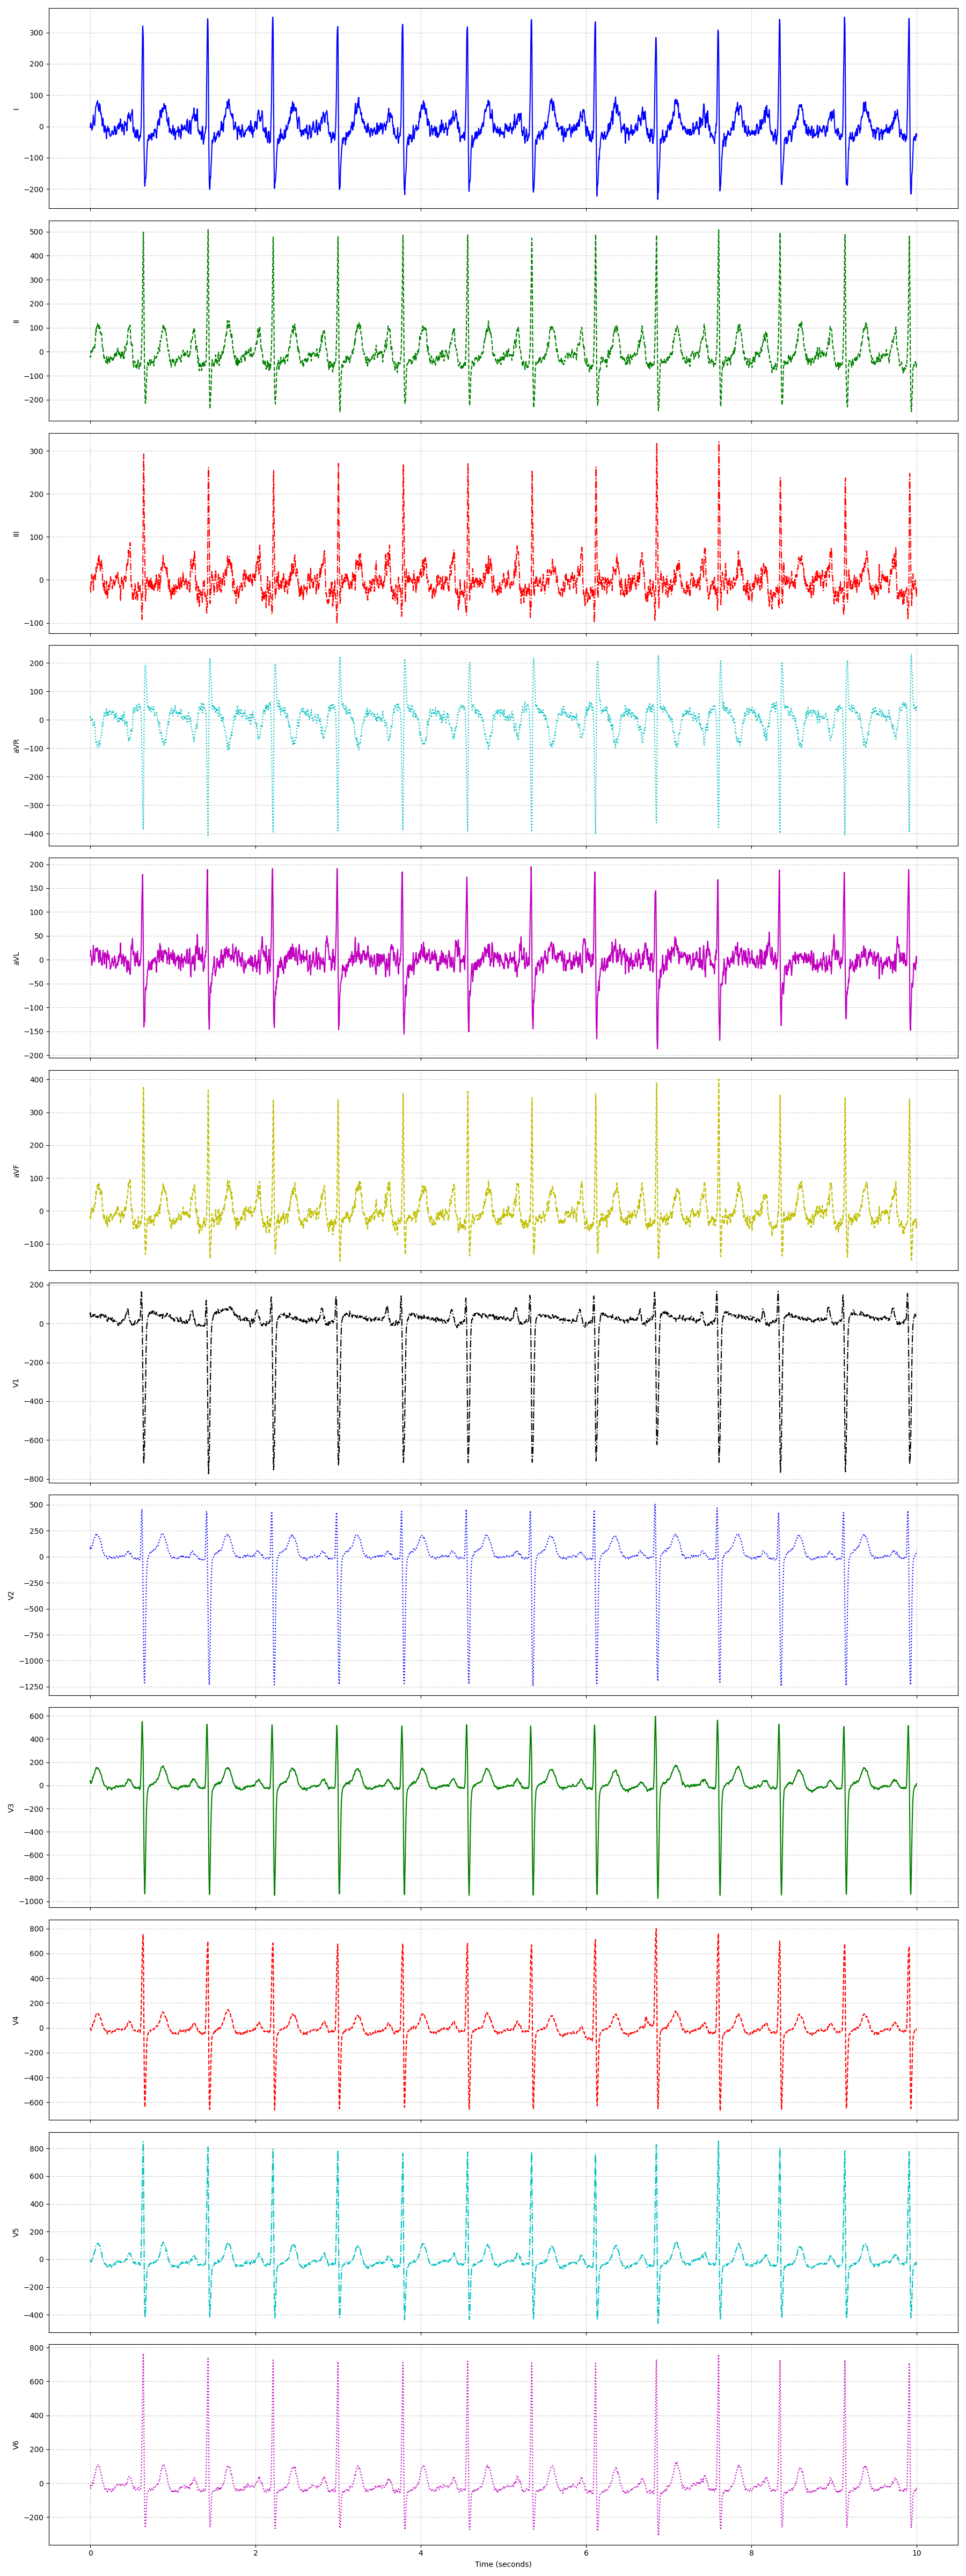

In [ ]:
plot_to_pil(ecg_signal, header.fs)

In [ ]:
def ecg_image(ecg_data, sample_frequency):
    num_leads = ecg_data.shape[0]
    duration = ecg_data.shape[1] / sample_frequency
    time_values = np.linspace(0, duration, ecg_data.shape[1])

    fig, axs = plt.subplots(num_leads, 1, figsize=(18, 4 * num_leads), sharex=True)

    line_styles = ['-', '--', '-.', ':']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i in range(num_leads):
        axs[i].plot(time_values, ecg_data[i], linestyle=line_styles[i % len(line_styles)], color=colors[i % len(colors)])
        axs[i].set_ylabel(header.sig_name[i])
        axs[i].grid(True, linestyle='--', alpha=0.6)


    axs[-1].set_xlabel('Time (seconds)')
    plt.tight_layout()


In [ ]:
# Specify the path to the g1 folder
g1_folder = Path('/content/drive/MyDrive/Datasets/training/cpsc_2018/g3')

# Specify the output folder for images
output_folder = g1_folder / 'images'

# Create the output folder if it doesn't exist
output_folder.mkdir(exist_ok=True)

# Function to process a single file
def process_file(file_path):
    file_path_string = str(file_path).split(".hea")[0]
    header = wfdb.rdheader(file_path_string)

    # Load .mat binary file
    mat_data = scipy.io.loadmat(f'{file_path_string}.mat')

    # Extract ECG signal
    ecg_signal = mat_data['val']

    # Generate and save the plot
    # plot_ecg_subplots(ecg_signal, header.fs)

    ecg_image(ecg_signal, header.fs)

    gc.collect()
    # Save the plot as a PNG image in the output folder
    image_name = f'{file_path.stem.lower()}_plot.png' if header.comments[2].split(": ")[1] == "164889003" else f'{file_path.stem}_plot.png'
    output_path = output_folder / f'{image_name}'
    print(output_path)
    plt.savefig(output_path)
    plt.close()  # Close the current plot to avoid overlapping
    gc.collect()

# Iterate through files in the g1 folder
files = set(g1_folder.glob('*.hea'))

# Use ThreadPoolExecutor to process files concurrently
with ThreadPoolExecutor() as executor:
    executor.map(process_file, files)

print("Plots saved successfully.")


/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2058_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2306_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2402_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2244_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2622_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2920_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2153_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2711_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2556_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2688_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/a2763_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2708_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2916_plot.png
/content/dri

<ipython-input-11-429723c1357e>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.savefig(output_path)


/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2247_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2698_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2023_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2814_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2182_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2264_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2224_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2685_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2191_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2993_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2359_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2829_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2470_plot.png
/content/dri

<ipython-input-7-abb2498e4d44>:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2670_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2062_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2926_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/a2978_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2898_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2005_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2842_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2175_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2397_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2198_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/A2290_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/a2725_plot.png
/content/drive/MyDrive/Datasets/training/cpsc_2018/g3/images/a2672_plot.png
/content/dri

In [ ]:
def get_ecg_items(path):
    files = get_files(path, extensions='.hea')
    return files

In [ ]:
def label_func(fname):

    file_path_string = str(fname).split(".hea")[0]
    header = wfdb.rdheader(file_path_string)

    return "AF" if header.comments[2].split(": ")[1] == "164889003" else "Non-AF"

In [ ]:
def label_func(fname):
    return "Non-AF" if fname.name[0].isupper() else "AF"

In [ ]:
def load_ecg_data(file_path):
    #print(file_path)
    file_path_string = str(file_path).split(".hea")[0]
    header = wfdb.rdheader(file_path_string)

    # Load .mat binary file
    mat_data = scipy.io.loadmat(f'{file_path_string}.mat')

    # Extract ECG signal
    ecg_signal = mat_data['val']

    #return ecg_spectrogram(ecg_signal, header.fs)

    return plot_to_pil(ecg_signal, header.fs)

In [ ]:
class BytesToImage(ItemTransform):
    def encodes(self, x: bytes):
        return Image.open(BytesIO(x))

In [ ]:
g1_folder = Path('/content/drive/MyDrive/Datasets/training/cpsc_2018/g1/images')

# Updated DataBlock
ecg_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    #get_items=get_ecg_items,
    get_items=get_image_files,
    #get_x=lambda x: load_ecg_data(x),  # Adjust with your actual data loading function
    get_y=label_func,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(256),
)

In [ ]:
dsets = ecg_data.datasets(g1_folder)
dsets.train[0]

(PILImage mode=RGB size=1800x4800, TensorCategory(1))

In [ ]:
dsets.vocab

['AF', 'Non-AF']

In [ ]:
# Create a DataLoader
dls = ecg_data.dataloaders(g1_folder)
dls.__dict__

{'loaders': [<fastai.data.core.TfmdDL at 0x7b9338a93850>,
 'path': Path('.'),
 '_device': device(type='cuda', index=0)}

In [ ]:
# Show a batch of data
dls.show_batch()